In [1]:

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
from torchvision import datasets, transforms
import torch.nn.functional as F

from AgeDatasetLoader import AgeDataset

In [2]:
class AgeDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)

        self.age_ranges = [
            "0-4",   "5-9",   "10-14", "15-19", "20-24",  "25-29", 
            "30-34", "35-39", "40-44", "45-49", "50-54",  "55-59",
            "60-64", "65-69", "70-74", "75-79", "80-84",  "85-89",
            "90-94", "95-99", "100-104","105-109","110-114","115-119"
        ]
        self.age_to_index = {age_str: i for i, age_str in enumerate(self.age_ranges)}

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # 1) Parse the pixel data
        pixel_str = self.data.iloc[idx]["pixels"]
        pixels = np.array(pixel_str.split(), dtype=np.float32)
        
        if len(pixels) != 48 * 48:
            raise ValueError(
                f"Expected 2304 pixels, got {len(pixels)} for index {idx}."
            )

        pixels = torch.tensor(pixels).view(1, 48, 48)

        age_range_str = self.data.iloc[idx]["label"]
        age_index = self.age_to_index[age_range_str]  
        
        return pixels, age_index

In [3]:
USE_GPU = True
num_class = 100
dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


print_every = 100

print('using device:', device)

using device: cuda


In [4]:
age_train = AgeDataset("age_data/age-train.csv")
loader_train = DataLoader(age_train, batch_size=32, shuffle=True, num_workers=2)

age_val = AgeDataset("age_data/age-val.csv")
loader_val = DataLoader(age_val, batch_size=32, shuffle=True, num_workers=2)


age_test = AgeDataset("age_data/age-test.csv")
loader_test = DataLoader(age_test, batch_size=32, shuffle=True, num_workers=2)



In [5]:
def check_accuracy(loader, model):
    print("iniating check acc func")
    print("checking accuracy of dataset")  
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

In [6]:


def train_b(model, optimizer, epochs=1):
    Loss = []
    acc_values = []
    print("iniating train func")
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            
            
        
          #  print(scores.size())
          #  print(x.size(), y.size())
            loss = F.cross_entropy(scores, y)
            
            Loss.append(loss.item())

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
      
            if (t + 1) % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t + 1, loss.item()))
                acc = check_accuracy(loader_val, model)
                acc_values.append(acc)
                print()
    return check_accuracy(loader_val, model)

In [7]:
def test(model, optimizer, epochs=1):
    Loss = []
    acc_values = []
    print("iniating train func")
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            
            loss = F.cross_entropy(scores, y)
            
            Loss.append(loss.item())

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
      
            if (t + 1) % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t + 1, loss.item()))
                acc = check_accuracy(loader_val, model)
                acc_values.append(acc)
                print()
    return check_accuracy(loader_val, model)

In [8]:
class VGG_16(nn.Module):
    def __init__(self):
        super(VGG_16, self).__init__()
        
        self.conv1_1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.bn1_1 = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn1_2 = nn.BatchNorm2d(64)
        self.max1 = nn.MaxPool2d((2,2), stride=2)
        
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(128)
        self.max2 = nn.MaxPool2d((2, 2), stride=2)


        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(256)
        self.max3 = nn.MaxPool2d((2, 2), stride=2)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4_1 = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn4_2 = nn.BatchNorm2d(512)

        self.max4 = nn.MaxPool2d((2, 2), stride=2)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_1 = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_2 = nn.BatchNorm2d(512)

        self.fc1 = nn.Linear(4608, 512)
        self.fc2 = nn.Linear(512, 24)
        self.fc3 = nn.Linear(24, 24) 
        self.dropout = nn.Dropout(0.5)
        self.relu =  nn.ReLU(inplace=True)
   


    def forward(self,x):

         x = self.conv1_1(x)
         x = self.bn1_1(x)
         x = self.relu(x)
         x = self.conv1_2(x)
         x = self.bn1_2(x)
         x = self.relu(x)
         x = self.max1(x)


         x = self.conv2_1(x)
         x = self.bn2_1(x)
         x = self.relu(x)
         x = self.conv2_2(x)
         x = self.bn2_2(x)
         x = self.relu(x)
         x = self.max2(x)


         x = self.conv3_1(x)
         x = self.bn3_1(x)
         x = self.relu(x)
         x = self.conv3_2(x)
         x = self.bn3_2(x)
         x = self.relu(x)
         x = self.max3(x)



         x = self.conv4_1(x)
         x = self.bn4_1(x)
         x = self.relu(x)
         x = self.conv4_2(x)
         x = self.bn4_2(x)
         x = self.relu(x)
         x = self.max4(x)


         x = self.conv5_1(x)
         x = self.bn5_1(x)
         x = self.relu(x)
         x = self.conv5_2(x)
         x = self.bn5_2(x)
         x = self.relu(x)

         x = x.view(x.size(0), -1)
         x = self.fc1(x)
         x = self.fc2(x)
         x = self.fc3(x)
        

         return x

In [9]:

model = VGG_16();
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


print_every = 500
train(model, optimizer, epochs=10)
print_every = 100

iniating train func
Epoch 0, Iteration 500, loss = 2.2730
iniating check acc func
checking accuracy of dataset
Got 767 / 3556 correct (21.57)

Epoch 1, Iteration 500, loss = 1.7797
iniating check acc func
checking accuracy of dataset
Got 1097 / 3556 correct (30.85)

Epoch 2, Iteration 500, loss = 2.0004
iniating check acc func
checking accuracy of dataset
Got 1114 / 3556 correct (31.33)

Epoch 3, Iteration 500, loss = 1.7356
iniating check acc func
checking accuracy of dataset
Got 1160 / 3556 correct (32.62)

Epoch 4, Iteration 500, loss = 1.6871
iniating check acc func
checking accuracy of dataset
Got 1241 / 3556 correct (34.90)

Epoch 5, Iteration 500, loss = 1.7383
iniating check acc func
checking accuracy of dataset
Got 1270 / 3556 correct (35.71)

Epoch 6, Iteration 500, loss = 1.8585
iniating check acc func
checking accuracy of dataset
Got 1131 / 3556 correct (31.81)

Epoch 7, Iteration 500, loss = 1.5832
iniating check acc func
checking accuracy of dataset
Got 1265 / 3556 correc

In [24]:
#Trying SGD optimizer
model = VGG_16();
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)


print_every = 500
train(model, optimizer, epochs=10)
print_every = 100

iniating train func
Epoch 0, Iteration 500, loss = 2.1997
iniating check acc func
checking accuracy of dataset
Got 1026 / 3556 correct (28.85)

Epoch 1, Iteration 500, loss = 2.0169
iniating check acc func
checking accuracy of dataset
Got 1057 / 3556 correct (29.72)

Epoch 2, Iteration 500, loss = 2.0024
iniating check acc func
checking accuracy of dataset
Got 1155 / 3556 correct (32.48)

Epoch 3, Iteration 500, loss = 1.7900
iniating check acc func
checking accuracy of dataset
Got 1138 / 3556 correct (32.00)

Epoch 4, Iteration 500, loss = 1.8289
iniating check acc func
checking accuracy of dataset
Got 1196 / 3556 correct (33.63)

Epoch 5, Iteration 500, loss = 1.7446
iniating check acc func
checking accuracy of dataset
Got 1230 / 3556 correct (34.59)

Epoch 6, Iteration 500, loss = 1.8901
iniating check acc func
checking accuracy of dataset
Got 1189 / 3556 correct (33.44)

Epoch 7, Iteration 500, loss = 1.5047
iniating check acc func
checking accuracy of dataset
Got 1165 / 3556 corre

In [26]:
#Tuning learning rate

accuracy_values = []
lr_values = []

for i in range(1,7):
    model = VGG_16();
    lr_hp = 10 ** (-1*i)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr_hp)
   
    print_every = 5000
    acc = train(model, optimizer, epochs=10)
    print("lr ",lr_hp,"acc ", acc)
    accuracy_values.append(acc)
    lr_values.append(lr_hp)


iniating train func
iniating check acc func
checking accuracy of dataset
Got 763 / 3556 correct (21.46)
lr  0.1 acc  0.21456692913385828
iniating train func
iniating check acc func
checking accuracy of dataset
Got 1219 / 3556 correct (34.28)
lr  0.01 acc  0.34280089988751405
iniating train func
iniating check acc func
checking accuracy of dataset
Got 1332 / 3556 correct (37.46)
lr  0.001 acc  0.374578177727784
iniating train func
iniating check acc func
checking accuracy of dataset
Got 1273 / 3556 correct (35.80)
lr  0.0001 acc  0.35798650168728907
iniating train func
iniating check acc func
checking accuracy of dataset
Got 1036 / 3556 correct (29.13)
lr  1e-05 acc  0.29133858267716534
iniating train func
iniating check acc func
checking accuracy of dataset
Got 1117 / 3556 correct (31.41)
lr  1e-06 acc  0.3141169853768279


The optimal learning rate was found to be 0.001

In [28]:
#tuning weight_decay
accuracy_values = []
wd_values = []

for i in range(1,7):
    model = VGG_16();
    wd_hp = 10 ** (-1*i)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = wd_hp)
   
    print_every = 5000
    acc = train(model, optimizer, epochs=10)
    print("weight_decay ",wd_hp,"acc ", acc)
    accuracy_values.append(acc)
    wd_values.append(wd_hp)

iniating train func
iniating check acc func
checking accuracy of dataset
Got 765 / 3556 correct (21.51)
weight_decay  0.1 acc  0.21512935883014622
iniating train func
iniating check acc func
checking accuracy of dataset
Got 1210 / 3556 correct (34.03)
weight_decay  0.01 acc  0.34026996625421824
iniating train func
iniating check acc func
checking accuracy of dataset
Got 1224 / 3556 correct (34.42)
weight_decay  0.001 acc  0.344206974128234
iniating train func
iniating check acc func
checking accuracy of dataset
Got 1283 / 3556 correct (36.08)
weight_decay  0.0001 acc  0.3607986501687289
iniating train func
iniating check acc func
checking accuracy of dataset
Got 1337 / 3556 correct (37.60)
weight_decay  1e-05 acc  0.37598425196850394
iniating train func
iniating check acc func
checking accuracy of dataset
Got 1348 / 3556 correct (37.91)
weight_decay  1e-06 acc  0.37907761529808776


The optimal weight decay was found to be 0.000001

In [29]:
#Tuning epochs
accuracy_values = []
epoch_values = []

for i in range(10,100,20):
    model = VGG_16();
  
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.000001)
   
    print_every = 5000
    acc = train(model, optimizer, epochs=i)
    print("epoch",i,"acc", acc)
    accuracy_values.append(acc)
    epoch_values.append(i)

iniating train func
iniating check acc func
checking accuracy of dataset
Got 1364 / 3556 correct (38.36)
epoch 10 acc 0.38357705286839144
iniating train func
iniating check acc func
checking accuracy of dataset
Got 1272 / 3556 correct (35.77)
epoch 30 acc 0.3577052868391451
iniating train func
iniating check acc func
checking accuracy of dataset
Got 1313 / 3556 correct (36.92)
epoch 50 acc 0.36923509561304835
iniating train func
iniating check acc func
checking accuracy of dataset
Got 1291 / 3556 correct (36.30)
epoch 70 acc 0.36304836895388076
iniating train func
iniating check acc func
checking accuracy of dataset
Got 1269 / 3556 correct (35.69)
epoch 90 acc 0.3568616422947132


The optimal number of epochs appears to be 10 epochs 

In [9]:
def check_accuracy(loader, model, device = 'cuda', dtype=torch.float32):
   # model.to(device)
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            
            scores = model(x)
            
            loss = F.cross_entropy(scores, y, reduction='sum')
            total_loss += loss.item()
            
            _, preds = scores.max(dim=1)
            total_correct += (preds == y).sum().item()
            total_samples += y.size(0)
    
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

In [10]:
import matplotlib.pyplot as plt
def train(model, optimizer, loader_train, loader_val, epochs=1, device='cuda', dtype=torch.float32):
    model = model.to(device=device)

    train_epochs = []
    train_losses = []
    train_accuracies = []
    
    val_epochs = []
    val_losses = []
    val_accuracies = []

    num_batches_per_epoch = len(loader_train)  
    half_epoch_interval = num_batches_per_epoch // 2  

    iteration = 0  

    for epoch in range(epochs):
        model.train()
        for batch_idx, (x, y) in enumerate(loader_train):
            iteration += 1

            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, preds = scores.max(dim=1)
            batch_acc = (preds == y).float().mean().item()

            if (batch_idx + 1) % half_epoch_interval == 0:
                epoch_progress = epoch + (batch_idx + 1) / num_batches_per_epoch 
                
                val_loss, val_acc = check_accuracy(loader_val, model, device, dtype)

                train_epochs.append(epoch_progress)
                train_losses.append(loss.item())
                train_accuracies.append(batch_acc)

                val_epochs.append(epoch_progress)
                val_losses.append(val_loss)
                val_accuracies.append(val_acc)

                print(f"Epoch [{epoch_progress:.1f}/{epochs}], "
                      f"Train Loss: {loss.item():.4f}, Train Acc: {batch_acc*100:.2f}% "
                      f"| Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

    final_val_loss, final_val_acc = check_accuracy(loader_val, model, device, dtype)
    print(f"Finished training. Final val loss = {final_val_loss:.4f}, val acc = {final_val_acc*100:.2f}%")

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(train_epochs, train_losses, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')

    plt.subplot(1,2,2)
    plt.plot(train_epochs, train_accuracies, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(val_epochs, val_losses, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation Loss')

    plt.subplot(1,2,2)
    plt.plot(val_epochs, val_accuracies, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')

    plt.tight_layout()
    plt.show()
    return final_val_loss, final_val_acc


Epoch [0.5/10], Train Loss: 2.4296, Train Acc: 21.88% | Val Loss: 2.6117, Val Acc: 17.01%
Epoch [1.0/10], Train Loss: 2.4375, Train Acc: 21.88% | Val Loss: 2.4914, Val Acc: 25.28%
Epoch [1.5/10], Train Loss: 2.1760, Train Acc: 34.38% | Val Loss: 2.5158, Val Acc: 26.07%
Epoch [2.0/10], Train Loss: 2.4907, Train Acc: 21.88% | Val Loss: 2.5103, Val Acc: 26.72%
Epoch [2.5/10], Train Loss: 1.9832, Train Acc: 31.25% | Val Loss: 2.3421, Val Acc: 24.97%
Epoch [3.0/10], Train Loss: 2.4072, Train Acc: 31.25% | Val Loss: 2.0563, Val Acc: 31.10%
Epoch [3.5/10], Train Loss: 2.0433, Train Acc: 21.88% | Val Loss: 2.0634, Val Acc: 29.05%
Epoch [4.0/10], Train Loss: 1.9700, Train Acc: 28.12% | Val Loss: 1.9454, Val Acc: 32.11%
Epoch [4.5/10], Train Loss: 1.8460, Train Acc: 31.25% | Val Loss: 1.9037, Val Acc: 31.64%
Epoch [5.0/10], Train Loss: 1.4657, Train Acc: 46.88% | Val Loss: 1.8297, Val Acc: 33.18%
Epoch [5.5/10], Train Loss: 2.1181, Train Acc: 21.88% | Val Loss: 1.7768, Val Acc: 34.73%
Epoch [6.0

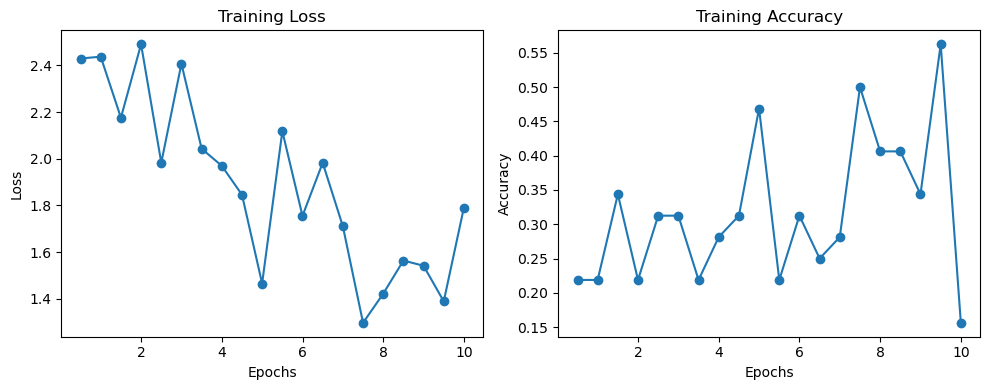

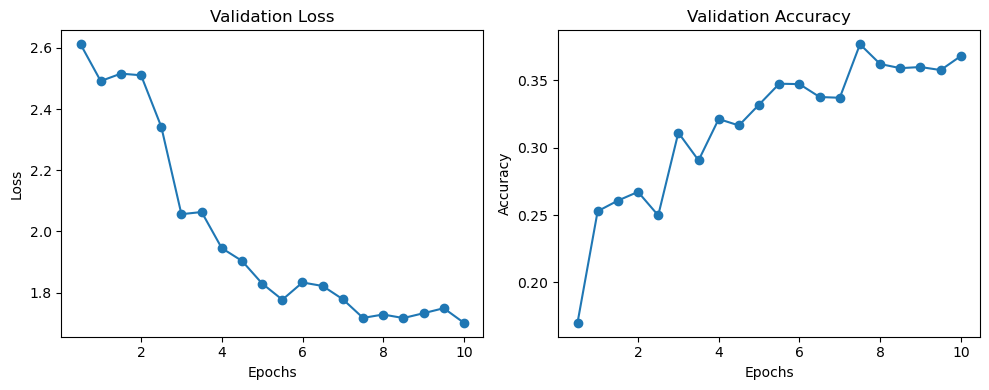

In [17]:
model = VGG_16();
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.000001)

final_accuracy = train(model, optimizer, loader_train, loader_val, epochs=10)

In [18]:

test_loss, test_acc = check_accuracy(loader_test, model)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%")

Test Loss: 1.6880, Test Accuracy: 38.10%


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
def create_heatmap(loader, model, device='cuda', dtype=torch.float32):
  

    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    y_pred = []  # Store predictions
    y_true = []  # Store actual labels

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y, reduction='sum')
            total_loss += loss.item()

            _, preds = scores.max(dim=1)  # Get predicted class labels
            y_pred.extend(preds.cpu().numpy())  # Convert to list and store
            y_true.extend(y.cpu().numpy())  # Store actual labels

            total_correct += (preds == y).sum().item()
            total_samples += y.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    cm = confusion_matrix(y_true, y_pred)
    class_labels = ["0-4", "5-9", "10-14", "15-19", "20-24", "25-29",
                   "30-34", "35-39", "40-44", "45-49", "50-54", "55-59",
                   "60-64", "65-69", "70-74", "75-79", "80-84", "85-89",
                   "90-94", "95-99", "100-104", "105-109", "110-114", "115-119"]
    plt.figure(figsize=(10,9))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("VGG-16 Model Heatmap")
    plt.show()
    return None
    


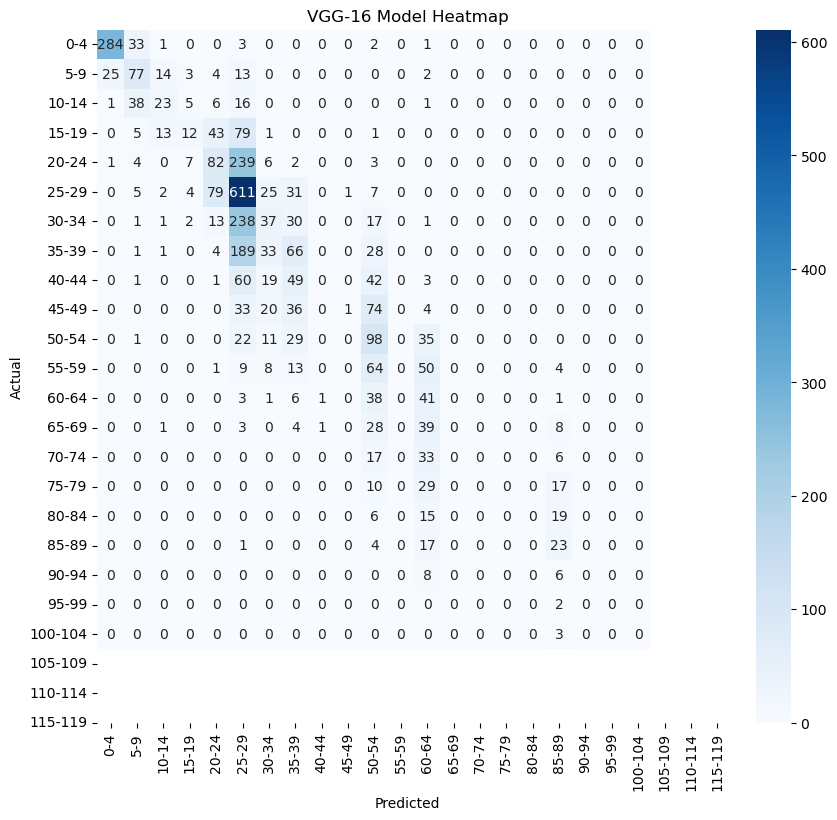

In [24]:
create_heatmap(loader_test, model)